# Model Versions

Fiddler is the pioneer in enterprise Model Performance Management (MPM), offering a unified platform that enables Data Science, MLOps, Risk, Compliance, Analytics, and other LOB teams to monitor, explain, analyze, and improve ML deployments at enterprise scale. Obtain contextual insights at any stage of the ML lifecycle, improve predictions, increase transparency and fairness, and optimize business revenue.

One of the features, the platform supports is Model versioning.

In this notebook, we present the steps for updating a model schema/version.  When a model is onboarded on to fiddler as a version 1, there can be multiple incremental updates or iterations to that model, the history to which is maintained in fiddler, called model versioning. The users can update existing model schema/versions and also access the older versions. 

This notebook is an example of how changes can be made in a model/schema and how fiddler maintains them.

# Model Versioning steps

This notebook creates different scenarios for adding new versions for a model.


1. Model Versions are supported on fiddler client version 3.1.0 and above. 
2. Make sure that the python version is 3.10 and above
3. Connect to fiddler - Initialisation, Load a Data Sample, Utility Methods
4. Create a Project
5. Create a first version of model
6. Create a second version
7. Create a third version
8. Create a fourth version
9. Create a fifth version
10. Update version name
11. List Model Versions
12. Delete a model version
13. Reference Documentation


In [1]:
!pip install -q fiddler-client==3.1.1

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
print(sys.version)

3.10.11 (main, May  7 2024, 15:20:43) [Clang 15.0.0 (clang-1500.3.9.4)]


In [3]:
import fiddler as fdl
import tempfile
import time as time
import numpy as np
import pandas as pd
import logging
from uuid import uuid4
from datetime import datetime, timedelta

fdl.__version__

'3.1.1'

# Set log levels

Set the log level for verbose information. Python Client mostly focus on programatic usage, rather than being interactive. Set the log level appropriately for notebook friendly usage.

In [4]:
fdl.set_logging(level=logging.DEBUG)

# Connect to Fiddler

Before you can add information about your model with Fiddler, you'll need to connect using our Python client.

---

**We need a few pieces of information to get started.**
1. The URL you're using to connect to Fiddler
3. Your authorization token

The latter two of these can be found by pointing your browser to your Fiddler URL and navigating to the **Settings** page.

In [5]:
URL = 'https://preprod.fiddler.ai' # UPDATE ME
TOKEN = 'CeuuMWP0FEJ7c6baVj8Kv5wbXnZHv6_OVexsZUG54IQ' # UPDATE ME

# Initialization

Initilize the connection to Fiddler Client. This call will also validate the client vs server version compatibility.

In [6]:
fdl.init(url=URL, token=TOKEN)

print(f'Client version: {fdl.__version__}')
print(f'Server version: {fdl.conn.server_version}')
print(f'Organization id: {fdl.conn.organization_id}')
print(f'Organization name: {fdl.conn.organization_name}')

2024-05-15 13:47:39,042 [fiddler.libs.http_client:65] DEBUG: Making GET call to /v3/server-info
2024-05-15 13:47:47,111 [fiddler.libs.http_client:65] DEBUG: Making GET call to /v3/version-compatibility
Client version: 3.1.1
Server version: 24.6.0-RC0
Organization id: 080289a6-f9dc-4e8a-90ed-63a41393bf83
Organization name: preprod


# Load a Data Sample

In [7]:
DATASET_FILE_PATH = "https://raw.githubusercontent.com/fiddler-labs/fiddler-examples/main/quickstart/data/v3/churn_data_sample.csv" # UPDATE ME    
PROJECT_NAME = 'konark_project_1' # UPDATE ME
DATASET_NAME = 'dataset_1' # UPDATE ME
MODEL_NAME = 'model_1' # UPDATE ME

Drop some output columns from the CSV file and pick the columns for inputs

In [8]:
sample_df = pd.read_csv(DATASET_FILE_PATH)
column_list  = sample_df.columns

input_columns  = list(column_list.drop(["predicted_churn","churn", "customer_id", "timestamp"]))
# list(column_list.drop(["predicted_churn","churn", "customer_id", "timestamp"]))

# sample_df
input_columns

['creditscore',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'numofproducts',
 'hascrcard',
 'isactivemember',
 'estimatedsalary']

## Utility methods

In [23]:
def _add_timestamp(df, event_ts_col: str, start: datetime = datetime.now(), end: datetime = datetime.now() - timedelta(days=30)):
    """
    This function will add a random timestamp to df between
    two datetime objects - start and end.
    """
    start_time = start.timestamp() * 1000
    end_time = end.timestamp() * 1000
    df[event_ts_col] = np.linspace(start_time, end_time, df.shape[0]).astype(int)
    df.sort_values(by=[event_ts_col], ascending=True)

## Create project

In [9]:
try:
    # Create project
    project = fdl.Project(name=PROJECT_NAME).create()
    print(f'New project created with id = {project.id} and name = {project.name}')
except fdl.Conflict:
    # Get project by name
    project = fdl.Project.from_name(name=PROJECT_NAME)
    print(f'Loaded existing project with id = {project.id} and name = {project.name}')

2024-05-15 13:48:42,569 [fiddler.libs.http_client:65] DEBUG: Making POST call to /v3/projects
New project created with id = ba9e3f78-0300-459a-8816-87106376a945


In [10]:
for x in fdl.Project.list():
    print(f'Project: {x.id} - {x.name}')

2024-05-15 13:48:47,647 [fiddler.libs.http_client:65] DEBUG: Making GET call to /v3/projects
Project: 01472f25-f1f9-45c9-a6fa-84f086576dc0 - release_24_1_test_002
Project: 14810c40-b5b0-415d-87de-65c6d58a4beb - rails_test_005
Project: 7b086553-f7b0-4cce-902d-5ded4e4d5f21 - randomviwaqntvsc
Project: b6fd0753-76c2-4407-a412-1fd5a6fe560e - imbalance_cc_fraud_danny
Project: b913f9d2-d8b3-4942-9ff8-fe7011ac5fdb - fiddler_chatbot_feb_23
Project: b2fd2fe4-ff04-4935-a2b9-236b35be0623 - random_f100_zwrkwrttbw
Project: a7e2c308-9f73-4876-8c0f-607be9d1ace4 - fiddler_chatbot_barun_1
Project: 15f79951-fda6-43f0-989f-1627d9ccc110 - test_project
Project: 9eea1666-e879-4000-a55d-6e203aae585f - fiddler_chatbot_feb_23_2
Project: c03e8b1e-574d-4beb-8a95-486dd59c557e - credit_approval_danny
Project: 7383d27a-7f23-4547-8b9a-dcc2e7f68aaa - simple_test_kening
Project: ed1c60e2-e817-4848-91a6-19d4951774f8 - lending
Project: f7e1e184-2391-49e7-83d4-b66477991323 - quickstart_bofa
Project: 24508f03-533d-4a3f-807

## First version with no task

Create the first version of model in the project with NOT_SET task

In [13]:
version_v1 = 'v1'

model_spec = fdl.ModelSpec(
    inputs=input_columns,
    outputs=['predicted_churn'],
    targets=['churn'],
    metadata=['customer_id', 'timestamp'],
    decisions=[],
    custom_features=[],
)

try:
    model_v1 = fdl.Model.from_name(
        name=MODEL_NAME,
        project_id=project.id,
        version=version_v1
    )
    print(f'Loaded existing model with id = {model_v1.id}')
except fdl.NotFound:
    model_v1 = fdl.Model.from_data(
        source=sample_df, 
        name=MODEL_NAME, 
        version=version_v1,
        project_id=project.id,
        spec=model_spec,
        task=fdl.ModelTask.NOT_SET,
    )

    model_v1.create()
    print(f'New model created with id = {model_v1.id}')

2024-05-15 13:51:20,927 [fiddler.libs.http_client:65] DEBUG: Making GET call to /v3/models
2024-05-15 13:51:22,196 [fiddler.libs.http_client:65] DEBUG: Making POST call to /v3/files/upload
2024-05-15 13:51:24,801 [fiddler.libs.http_client:65] DEBUG: Making POST call to /v3/model-factory
2024-05-15 13:51:26,338 [fiddler.libs.http_client:65] DEBUG: Making POST call to /v3/models
New model created with id = d1020cc5-aac1-4af8-9bf3-73367149734a


## Second version with a task
Add Second version with binary classification task 
Update the age min/max, provide target class and binary classification thresholds

In [15]:
version_v2 = 'v2'

task_params = fdl.ModelTaskParams(
    binary_classification_threshold=0.5,
    target_class_order=['no', 'yes'],
    class_weights=None,
    group_by=None,
    top_k=None,
    weighted_ref_histograms=None,
)

try:
    model_v2 = fdl.Model.from_name(
        name=MODEL_NAME,
        project_id=project.id,
        version=version_v2
    )
    print(f'Loaded existing model with id = {model_v2.id}')
except fdl.NotFound:
    model_v2 = model_v1.duplicate(version=version_v2)
    model_v2.schema['age'].min = 21
    model_v2.schema['age'].max = 55
    model_v2.task_params = task_params
    model_v2.task = fdl.ModelTask.BINARY_CLASSIFICATION
    model_v2.create()
    print(f'New model created with id = {model_v2.id}')


2024-05-15 13:52:31,122 [fiddler.libs.http_client:65] DEBUG: Making GET call to /v3/models
2024-05-15 13:52:33,763 [fiddler.libs.http_client:65] DEBUG: Making POST call to /v3/models
New model created with id = a5e5b68b-ad7e-44ad-924a-03ad7efee3ea


## Third version with schema change
Add third version with change in schema
here we are changing the age min/max, deleting an input param, and renaming the Column names

In [16]:
version_v3 = 'v3'

try:
    model_v3 = fdl.Model.from_name(
        name=MODEL_NAME,
        project_id=project.id,
        version=version_v3
    )
    print(f'Loaded existing model with id = {model_v3.id}')
except fdl.NotFound:
    model_v3 = model_v2.duplicate(version=version_v3)
    model_v3.schema['creditscore'].name = 'CreditScore'
    model_v3.schema['geography'].name = 'Geography'
    model_v3.schema['balance'].name = 'BalanceNew'
    model_v3.schema['numofproducts'].name = 'NumOfProducts'
    model_v3.schema['hascrcard'].name = 'HasCrCard'
    model_v3.schema['isactivemember'].name = 'IsActiveMember'
    model_v3.schema['estimatedsalary'].name = 'EstimatedSalary'
    model_v3.schema['age'].name = 'Age'
    model_v3.schema['Age'].min = 18
    model_v3.schema['Age'].max = 85
    del model_v3.schema['tenure']

    model_v3.spec.inputs = ['CreditScore', 'Geography', 'Age', 'BalanceNew', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
    
    model_v3.create()
    print(f'New model created with id = {model_v3.id}')

2024-05-15 13:53:01,745 [fiddler.libs.http_client:65] DEBUG: Making GET call to /v3/models
2024-05-15 13:53:05,628 [fiddler.libs.http_client:65] DEBUG: Making POST call to /v3/models
New model created with id = 5a71f4d2-0a9d-4a25-b6cb-e872970dc2d4


## Fourth version with schema change
Add fourth version with change in schema, where 
we are changing the weights of the class, removing some input params, 

In [19]:
version_v4 = 'v4'

try:
    model_v4 = fdl.Model.from_name(
        name=MODEL_NAME,
        project_id=project.id,
        version=version_v4
    )
    print(f'Loaded existing model with id = {model_v4.id}')
except fdl.NotFound:
    model_v4 = model_v3.duplicate(version=version_v4)
    model_v4.schema['BalanceNew'].max = 250000

    # task_params = fdl.ModelTaskParams(
    #     class_weights = [23.0, 12.0, 25.0, 12.5, 12.5, 7.5, 7.5, 0.0],
    # weighted_ref_histograms = True,
    # )
    
    # model_v4.task_params = task_params    
    model_v4.create()
    print(f'New model created with id = {model_v4.id}')

2024-05-15 14:13:51,454 [fiddler.libs.http_client:65] DEBUG: Making GET call to /v3/models
konark is here 1st block 
Model not found for the given identifier
2024-05-15 14:13:53,737 [fiddler.libs.http_client:65] DEBUG: Making POST call to /v3/models
New model created with id = 3bc2380e-f9be-4a65-a305-357b37bb0566


## Fifth version with schema change
Add fifth version with change in schema, where 
we are changing the changing the max limit of the balance field

In [28]:
version_v5 = 'v5'

try:
    model_v5 = fdl.Model.from_name(
        name=MODEL_NAME,
        project_id=project.id,
        version=version_v5
    )
    print(f'Loaded existing model with id = {model_v4.id}')
except fdl.NotFound as e:
    model_v5 = model_v4.duplicate(version=version_v5)
    model_v5.schema['BalanceNew'].max = 1250000    
    model_v5.create()
    print(f'New model created with id = {model_v5.id}')


2024-05-15 14:20:15,726 [fiddler.libs.http_client:65] DEBUG: Making GET call to /v3/models
2024-05-15 14:20:17,937 [fiddler.libs.http_client:65] DEBUG: Making POST call to /v3/models
New model created with id = ab9da064-083b-456e-9115-cfc6e63428cf


## Update version name

In [25]:
model_v4.version = 'v4-old'
model_v4.update()

2024-05-15 14:17:19,465 [fiddler.libs.http_client:65] DEBUG: Making PATCH call to /v3/models/3bc2380e-f9be-4a65-a305-357b37bb0566


## List model versions

List all the versions of a model

In [26]:
for x in fdl.Model.list(project_id=project.id, name=MODEL_NAME):
    print(f'Model: {x.id} - {x.name} {x.version}')

2024-05-15 14:17:23,963 [fiddler.libs.http_client:65] DEBUG: Making GET call to /v3/models
Model: d1020cc5-aac1-4af8-9bf3-73367149734a - model_1 v1
Model: a5e5b68b-ad7e-44ad-924a-03ad7efee3ea - model_1 v2
Model: 5a71f4d2-0a9d-4a25-b6cb-e872970dc2d4 - model_1 v3
Model: 3bc2380e-f9be-4a65-a305-357b37bb0566 - model_1 v4-old
Model: 01723d01-6e31-4462-8e41-d8c29c2be1a8 - model_1 v5


## Delete model version
Delete v5 version

In [29]:
job = model_v5.delete()
job.wait()

2024-05-15 14:21:17,423 [fiddler.libs.http_client:65] DEBUG: Making DELETE call to /v3/models/ab9da064-083b-456e-9115-cfc6e63428cf
2024-05-15 14:21:17,961 [fiddler.libs.http_client:65] DEBUG: Making GET call to /v3/jobs/2cec4b7c-5096-4c3e-a3c0-3c7a1ea824c9
2024-05-15 14:21:18,293 [fiddler.libs.http_client:65] DEBUG: Making GET call to /v3/jobs/2cec4b7c-5096-4c3e-a3c0-3c7a1ea824c9
2024-05-15 14:21:18,590 [fiddler.entities.job:155] INFO: Model deletion[2cec4b7c-5096-4c3e-a3c0-3c7a1ea824c9]: status - STARTED, progress - 0.00%
2024-05-15 14:21:21,594 [fiddler.libs.http_client:65] DEBUG: Making GET call to /v3/jobs/2cec4b7c-5096-4c3e-a3c0-3c7a1ea824c9
2024-05-15 14:21:21,892 [fiddler.entities.job:155] INFO: Model deletion[2cec4b7c-5096-4c3e-a3c0-3c7a1ea824c9]: status - STARTED, progress - 0.00%
2024-05-15 14:21:24,894 [fiddler.libs.http_client:65] DEBUG: Making GET call to /v3/jobs/2cec4b7c-5096-4c3e-a3c0-3c7a1ea824c9
2024-05-15 14:21:25,181 [fiddler.entities.job:155] INFO: Model deletion[2

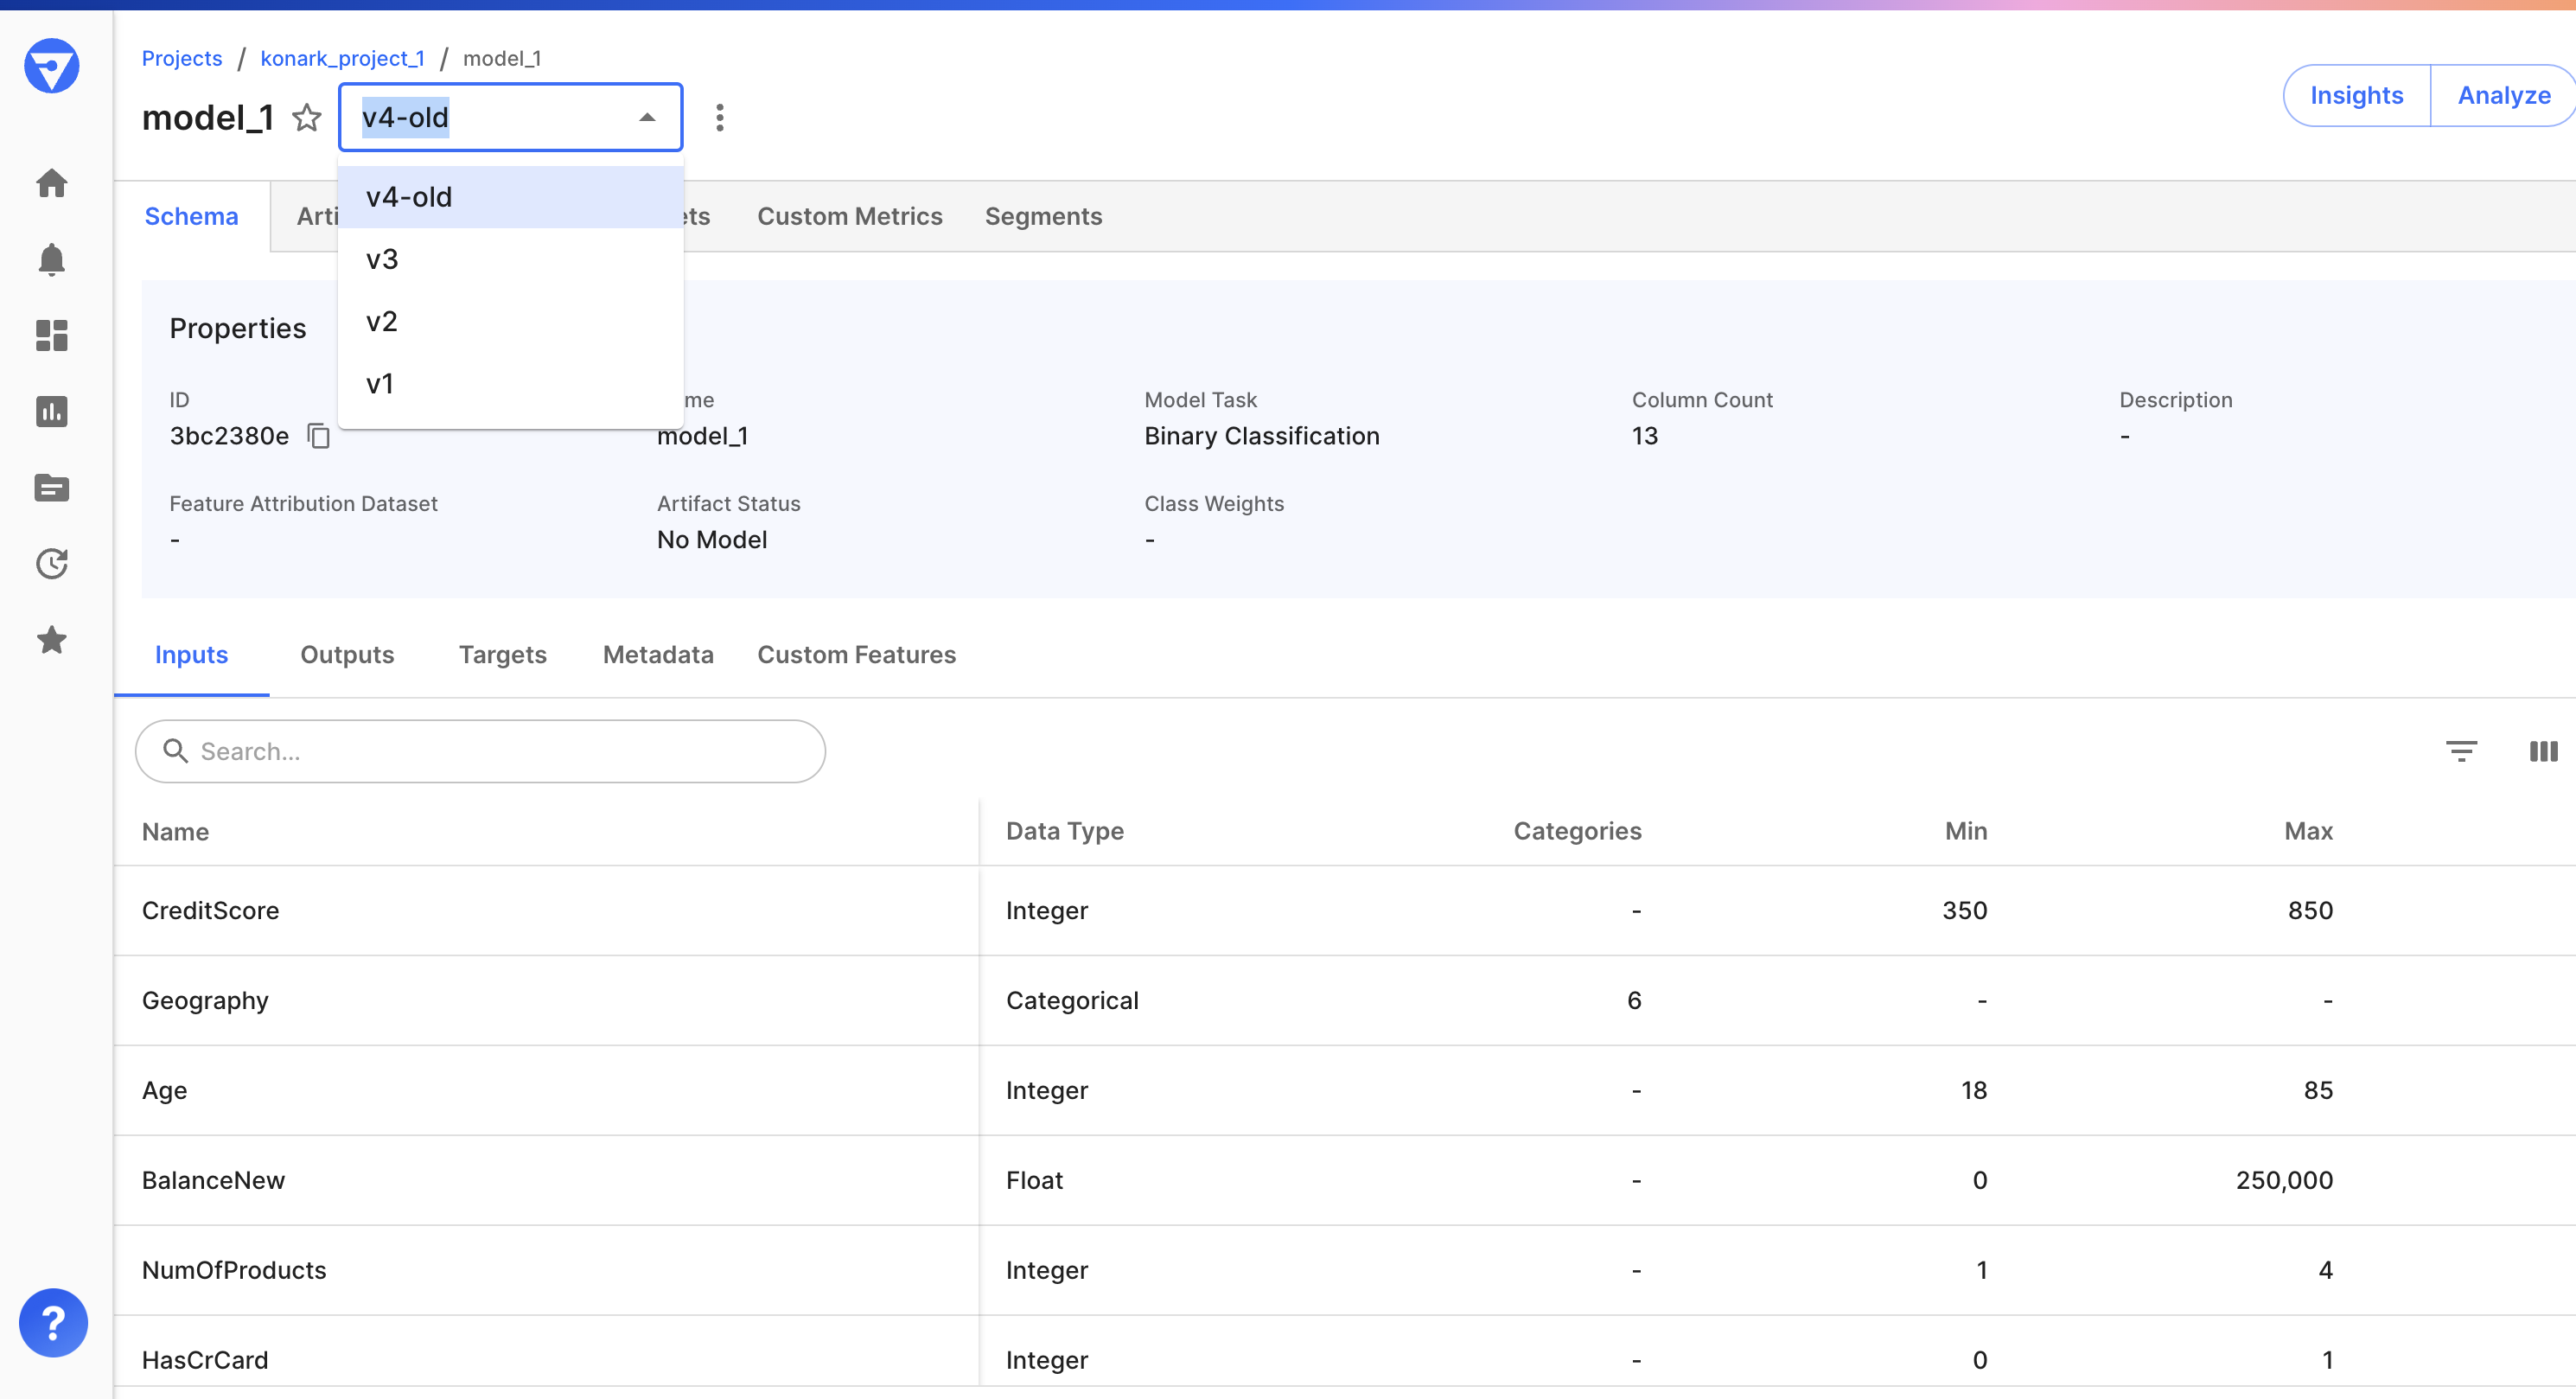

Model versioning docs can be referred [here](https://docs.fiddler.ai/docs/model-versions) 

**You're all done!**
  
Now just head to your Fiddler environment's UI and explore the model's explainability by navigating to the model and selecting the **Explain** tab on the top right.



---


**Questions?**  
  
Check out [our docs](https://docs.fiddler.ai/) for a more detailed explanation of what Fiddler has to offer.

If you're still looking for answers, fill out a ticket on [our support page](https://fiddlerlabs.zendesk.com/) and we'll get back to you shortly.